# Project Overview

In this notebook, we will build and evaluate a **machine learning regression model** to predict car prices (**https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data**) using advanced feature engineering and cross-validation techniques. The main steps include:

- Preparing the dataset with carefully crafted features, including target encoding and histogram aggregation.
- Implementing a nested K-Fold cross-validation scheme to prevent data leakage and ensure robust model evaluation.
- Training a **GPU-accelerated XGBoost Regressor** for efficient and powerful prediction.
- Evaluating model performance using out-of-fold predictions and computing overall cross-validation scores.
- Visualizing feature importances and comparing the predicted price distribution against actual prices to gain insights into model behavior.

This structured approach aims to deliver accurate and reliable price predictions while providing interpretability and validation for the results.


In [1]:
# Importing essential libraries for data manipulation, visualization, and modeling
import pandas as pd  # for data manipulation and analysis
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for basic plotting
import seaborn as sns  # for advanced data visualization

# Importing necessary scikit-learn modules
from sklearn.impute import SimpleImputer  # for handling missing values
from sklearn.model_selection import train_test_split  # for splitting data into train/test sets
from sklearn.cluster import KMeans  # for clustering (unsupervised learning)

# Import garbage collector module to manually free up memory when needed
import gc

# Setting display option to show more columns when printing dataframes
pd.set_option("display.max_columns", 500)

# Suppressing warnings for cleaner output
import warnings
warnings.simplefilter(action='ignore')


In [2]:
# Load the dataset into a DataFrame
data_full = pd.read_csv("/kaggle/input/craigslist-carstrucks-data/vehicles.csv")

# Display the first 5 rows to get a quick overview of the dataset
display(data_full.head(5))

# Print the shape of the dataset (rows, columns)
print(data_full.shape)

# Check for and count duplicate rows in the dataset
data_duplicates = data_full.duplicated().sum()
print(f"Number of duplicate rows in data: {data_duplicates}")


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


(426880, 26)
Number of duplicate rows in data: 0


In [3]:
# Create a copy of the original dataset to work on, preserving the original
data = data_full.copy()

# Define columns that are important for analysis
cols2 = ['manufacturer', 'model', 'cylinders', 'fuel', 'odometer',
         'transmission', 'drive', 'size', 'type']

# Drop rows where all of the specified columns are NaN
# This removes records that are missing too much relevant information
data = data.dropna(subset=cols2, how='all', axis=0).reset_index(drop=True)


In [4]:
# Create a summary table to inspect missing values, unique values, and data types for each feature
merged_df = pd.DataFrame({
    'Feature': data.columns,
    'No. of Missing Values': data.isnull().sum().values,  # Total missing values per column
    '% of Missing Values': (data.isnull().sum().values / len(data) * 100),  # Percentage of missing values
    'No. of Unique Values': data.nunique().values,  # Number of unique values per column
    'DataType': data.dtypes  # Data type of each column
})

# Display the summary DataFrame
merged_df


,Feature,No. of Missing Values,% of Missing Values,No. of Unique Values,DataType
id,id,0,0.000000,426812,int64
url,url,0,0.000000,426812,object
region,region,0,0.000000,404,object
region_url,region_url,0,0.000000,413,object
price,price,0,0.000000,15652,int64
year,year,1137,0.266394,114,float64
manufacturer,manufacturer,17578,4.118441,42,object
model,model,5209,1.220444,29667,object
condition,condition,174036,40.775798,6,object
cylinders,cylinders,177610,41.613169,8,object


In [5]:
# Remove unnecessary or irrelevant columns that won't be used in analysis or modeling
rmv = ['posting_date', 'county', 'description', 'image_url', 
       'region_url', 'id', 'url', 'VIN']
data = data.drop(rmv, axis=1)

# Identify numeric columns
nums = [col for col in data.columns if data[col].dtype in ["int64", "float64"]]

# Identify categorical columns
cats = [col for col in data.columns if data[col].dtype == "object"]

# Combine numeric and categorical column names (optional step, can be useful later)
cols = nums + cats

# Print the shape of the cleaned dataset
print(data.shape)


(426812, 18)


## 📊 Exploratory Data Analysis (EDA)

In this section, we'll explore the dataset to better understand the distribution, relationships, and patterns among the features. The primary goals of EDA are:

- To uncover underlying structure and insights  
- To detect outliers, anomalies, or missing values  
- To identify relationships between variables  
- To guide feature selection and preprocessing steps for modeling

We'll use visual and statistical techniques to gain a comprehensive understanding of both numerical and categorical features.


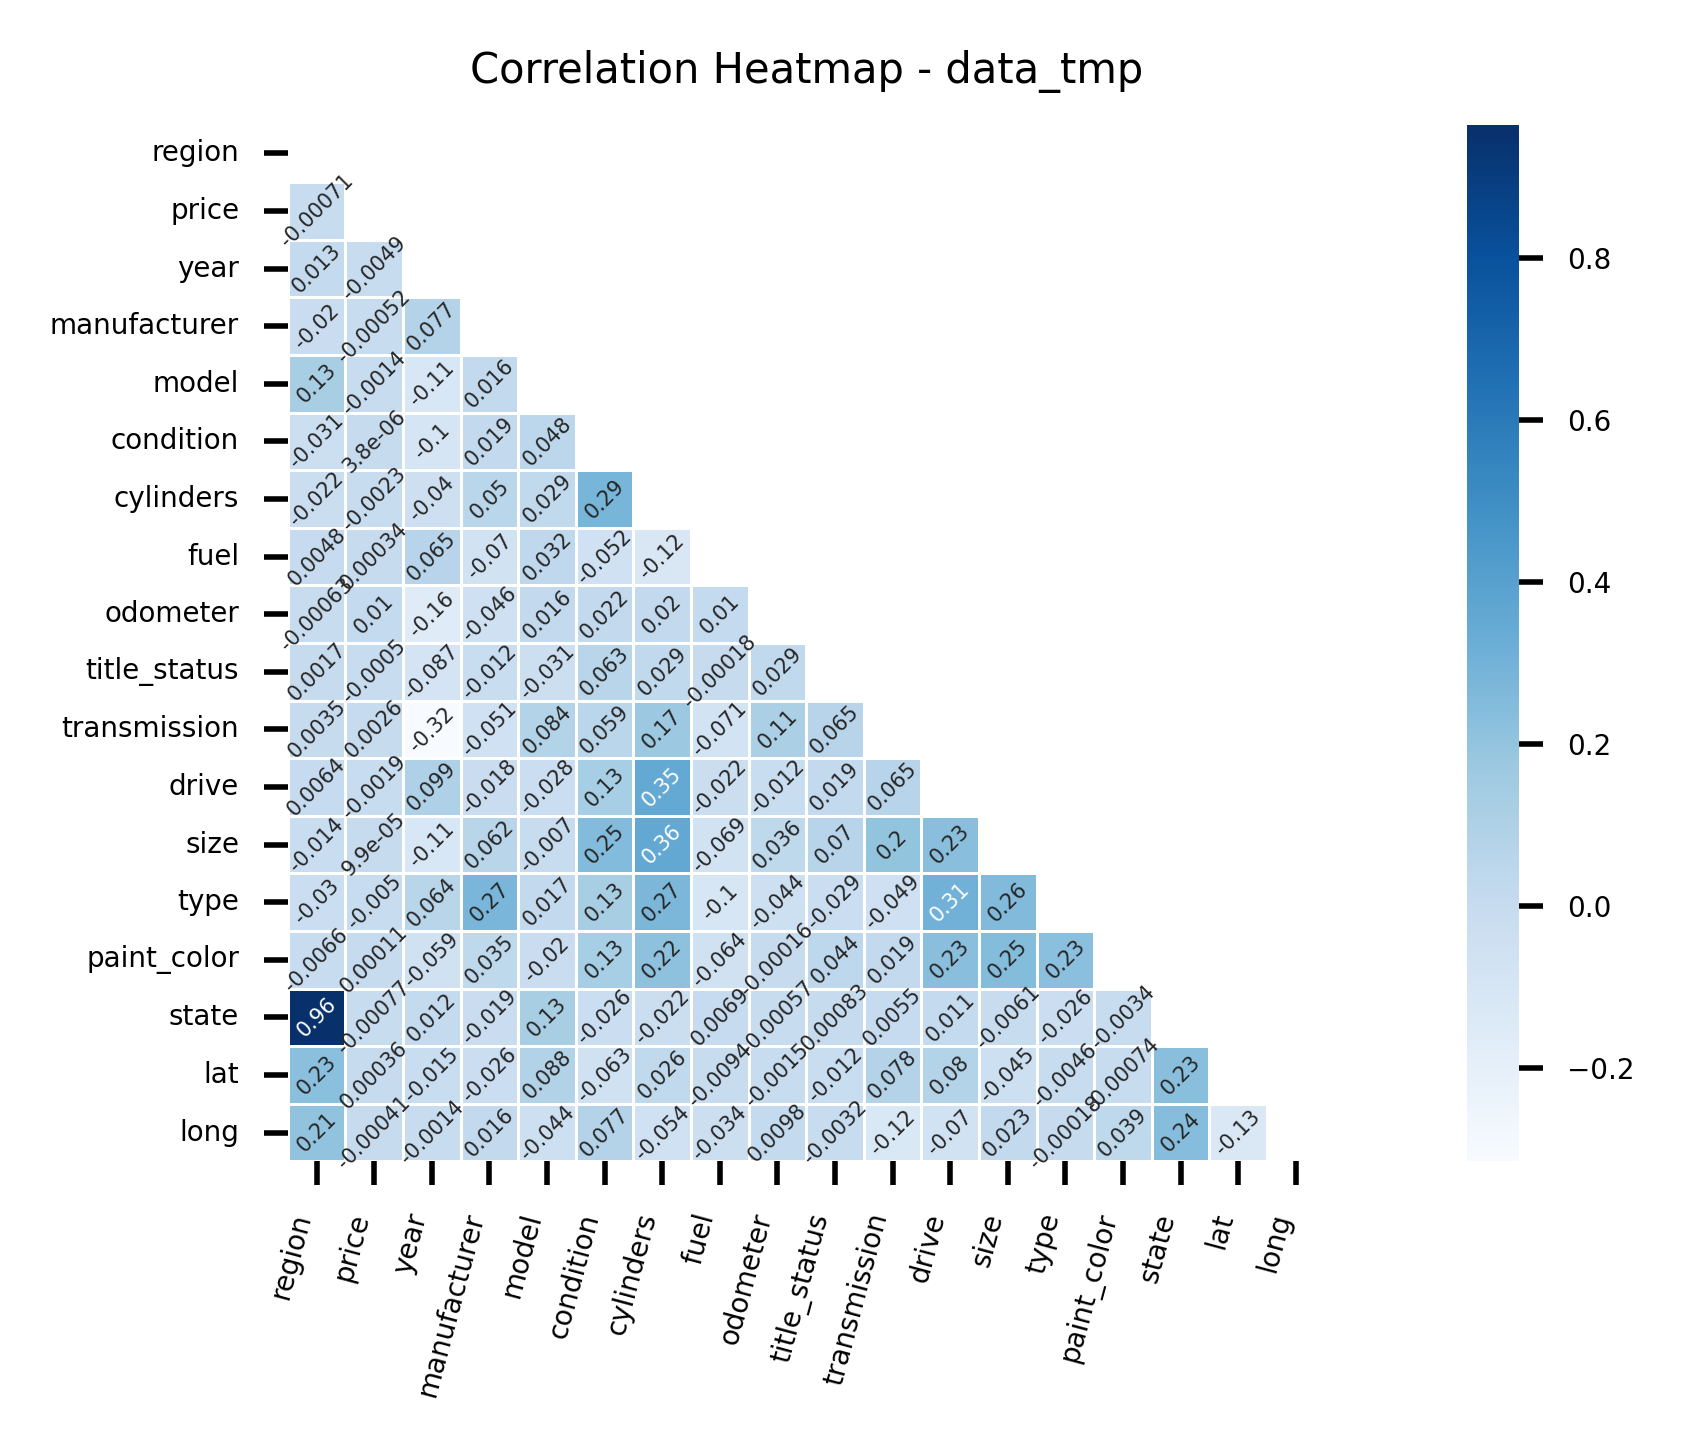

0

In [6]:
# Create a copy of the cleaned data for encoding and correlation analysis
data_tmp = data.copy()

# Encode categorical variables as numeric codes using pandas.factorize
# This converts categories into integer codes, allowing correlation computation
for i in cats:
    enc = data_tmp[i]
    enc, _ = pd.factorize(enc)
    data_tmp[i] = enc.astype("float32")  # Use float32 for memory efficiency

# Get list of all feature columns (numeric + encoded categorical)
variables = [col for col in data_tmp.columns]

# Calculate the correlation matrix for all features
corr_data_tmp = data_tmp.corr()

# Create a mask to hide the upper triangle of the heatmap (redundant info)
mask_train = np.triu(np.ones_like(corr_data_tmp, dtype=bool))

# Set annotation keyword arguments (text size and rotation for better readability)
annot_kws = {"size": 3, "rotation": 45}

# Plot the correlation heatmap
plt.figure(figsize=(6, 3), dpi=500)
ax_train = sns.heatmap(
    corr_data_tmp,
    mask=mask_train,
    cmap='Blues',
    annot=True,
    square=True,
    linewidths=0.2,
    xticklabels=corr_data_tmp.columns,
    yticklabels=corr_data_tmp.columns,
    annot_kws=annot_kws
)

# Add title with small font size for compact display
plt.title('Correlation Heatmap - data_tmp', fontsize=6)

# Reduce colorbar label font size for clarity
cbar = ax_train.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)

# Adjust font size and rotation of axis labels for readability
ax_train.set_xticklabels(ax_train.get_xticklabels(), fontsize=4, rotation=75, ha='right')
ax_train.set_yticklabels(ax_train.get_yticklabels(), fontsize=4, rotation=0)

# Use tight layout to prevent label cutoff
plt.tight_layout()

# Display the heatmap
plt.show()

del data_tmp
gc.collect()

array(['price', 'odometer'], dtype=object)

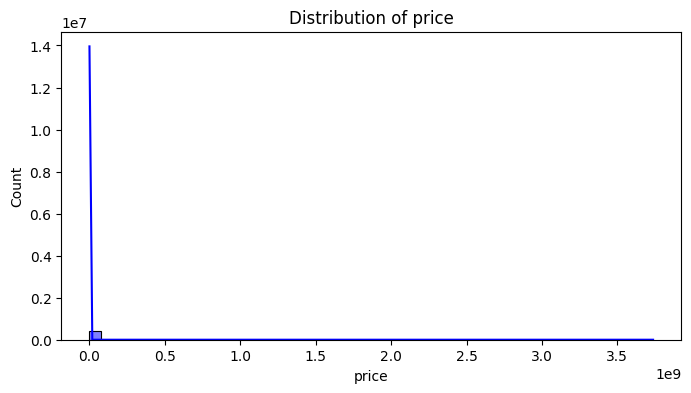

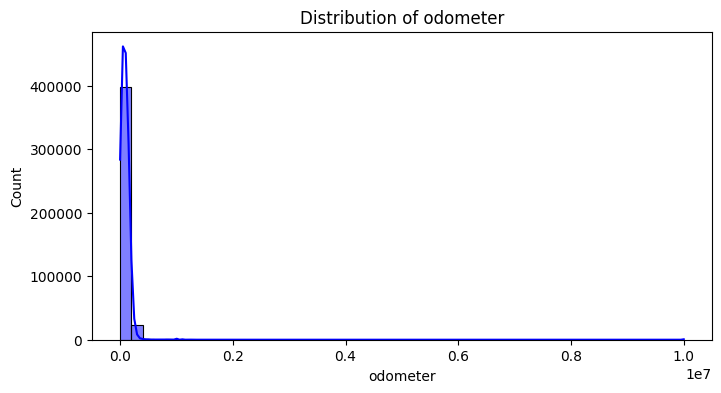

In [7]:
# Identify numeric features with high skewness (> 0.75)
# High skewness indicates the data is not normally distributed and may need transformation
skewed_features = data[nums].skew()[data[nums].skew() > 0.75].index.values
display(skewed_features)  # Display the list of skewed features

# Visualize the distribution of each skewed feature before any transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], bins=50, kde=True, color='blue')  # Histogram with KDE curve
    plt.title(f'Distribution of {feature}')
    plt.show()


In [8]:
# Since 'price' is skewed, let's inspect its distribution through descriptive statistics at various percentiles
# This helps understand the spread and presence of outliers in the price data
data['price'].describe(percentiles=[0.01, 0.05, 0.10, 0.11, 0.15, 0.20, 0.50, 0.80, 0.90, 0.99]) \
    .reset_index() \
    .set_index('index') \
    .T  # Transpose for better readability (percentiles become columns)


index,count,mean,std,min,1%,5%,10%,11%,15%,20%,50%,80%,90%,99%,max
price,426812.0,75209.273844,1.218325e+07,0.0,0.0,0.0,500.0,1000.0,3000.0,4500.0,13950.0,29777.0,37590.0,66995.0,3.736929e+09


## Using the Correlation Heatmap for Missing Data Handling and Feature Engineering

The correlation heatmap above helps us identify strong relationships between features.  
We will leverage these correlations to inform strategies for:  

- Handling missing data by imputing values based on correlated features  
- Creating or transforming features to improve model performance during feature engineering  


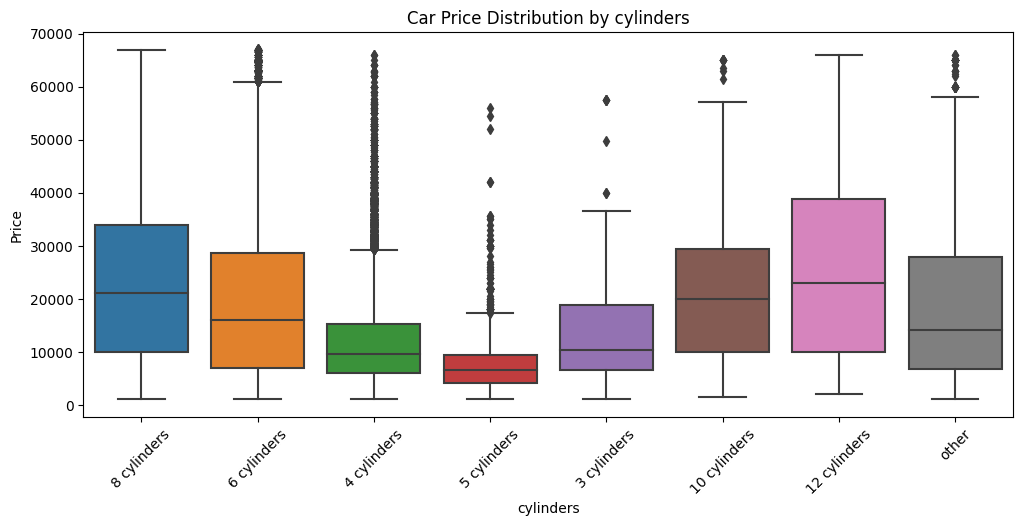

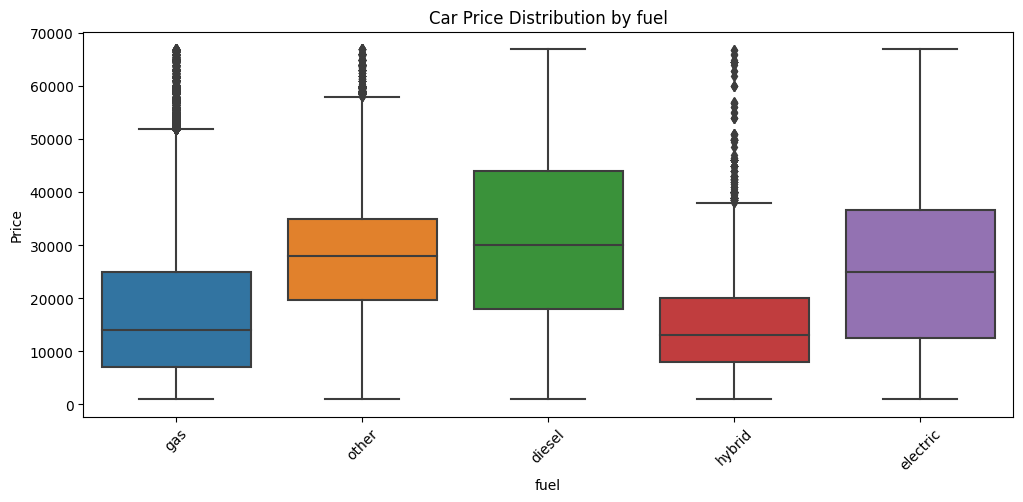

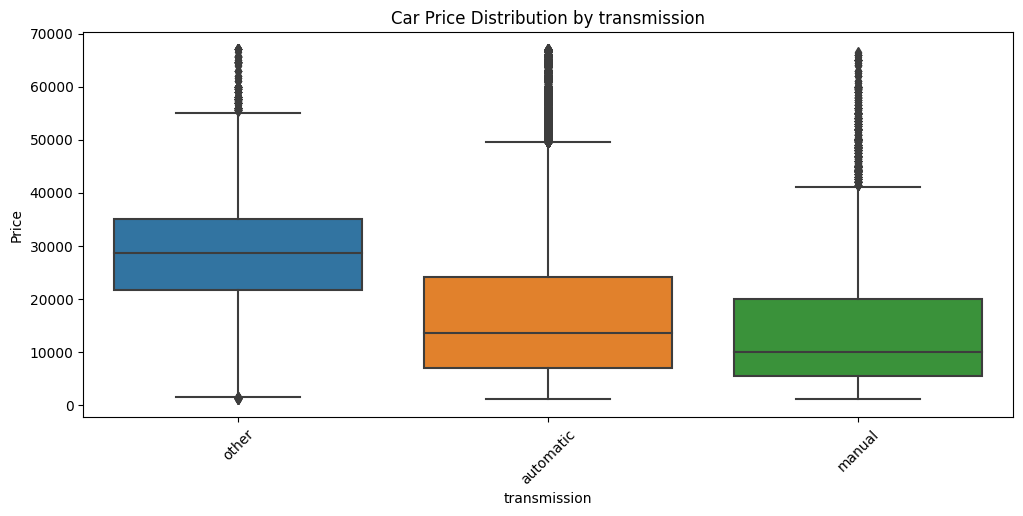

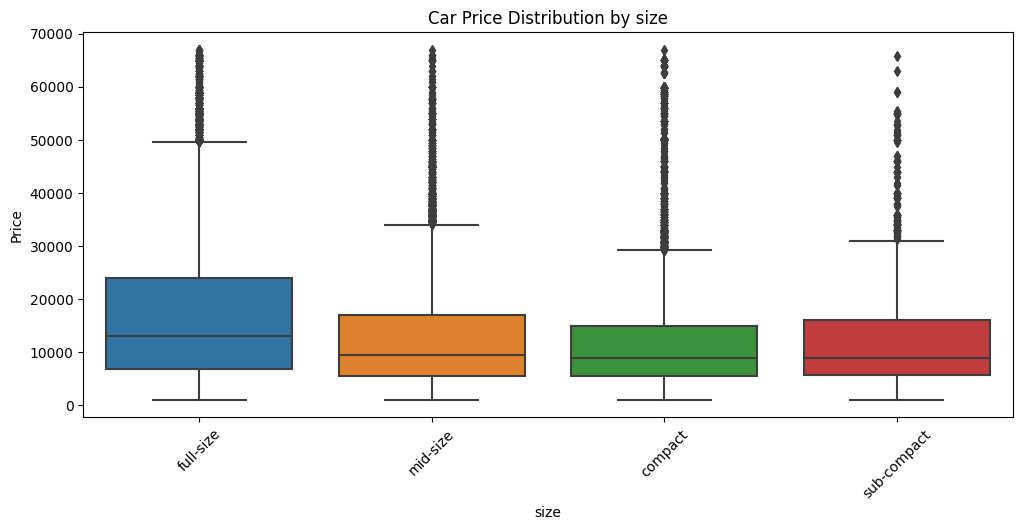

15644

In [9]:
# List of categorical features to analyze against price
cats_new = ['cylinders', 'fuel', 'transmission', 'size']

# Extract numeric values from 'cylinders' feature for sorting purposes
# Drop rows with NaN in 'cylinders' before processing
sort_cyl = data.dropna(subset=['cylinders'])

# Extract digits from 'cylinders' strings (e.g. "6 cylinders" → 6) and convert to float
sort_cyl.loc[:, 'cyl_num'] = sort_cyl['cylinders'].str.extract('(\d+)').astype(float).copy()

# Sort the unique cylinder types based on the numeric value extracted
ordered_cylinders = sort_cyl[['cylinders', 'cyl_num']].drop_duplicates().sort_values('cyl_num')['cylinders']

# Filter data to exclude extremely low prices (<1000) and outliers above 99th percentile
data_tmp2 = data[(data['price'] > 1000) & (data['price'] < data['price'].quantile(0.99))].copy()

# Plot boxplots to visualize price distributions by categorical variables in cats_new
for c in cats_new:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=c, y='price', data=data_tmp2)
    plt.title(f'Car Price Distribution by {c}')
    plt.xlabel(c)
    plt.ylabel('Price')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
    
del data_tmp2
gc.collect()

In [10]:
# Check how many cars are priced at $1000 or less (potentially low-value or erroneous listings)
data.loc[data['price'] <= 1000].shape


(47515, 18)

### 47,515 rows with 'price' <= 1000  
*We'll remove these low-price rows after addressing major missing values.*

## Handling Missing Data + Feature Engineering

In the next steps, we will focus on:  
- Handling missing data intelligently to prepare the dataset for modeling  
- Creating new features or transforming existing ones to improve predictive power  


In [11]:
# Models tend to be unique to specific car types, so we can use the 'model' feature to impute missing 'type' values.
# This approach should accurately fill NaNs in 'type' based on the associated model.

# Extract rows where 'type' is not missing, taking only 'type' and 'model' columns, and drop any NaNs in these two columns
model_match2 = data[['type', 'model']].loc[data['type'].notna(), ['type', 'model']].dropna()

# Create a dictionary mapping from model to type
model_to_type = dict(zip(model_match2['model'], model_match2['type']))

# Fill missing 'type' values by mapping the 'model' column using the dictionary
data['type'] = data['type'].fillna(data['model'].map(model_to_type))


In [12]:
# Initialize a new feature 'NaNs' to count and encode missing values across categorical columns
data['NaNs'] = np.float32(0)
COMBO=['NaNs']

# Remove 'price' from numerical columns list since we don't want to include it in this calculation
nums.remove('price')

# For each categorical feature, encode missingness and create combined features with numeric columns
for i, c in enumerate(cats):
    # Update 'NaNs' feature by adding a weighted value for missingness in the categorical column
    # The weight uses powers of 2 based on the categorical column index, creating a unique sum per missing pattern
    data['NaNs'] += data[c].isna() * 2**i

    # For each numeric column, create a new feature that combines the missingness of the categorical column 
    # and the value of the numeric column (with missing values filled by 0) in a specific formula.
    for j, n in enumerate(nums):
        q = f"{c}_nan_{n}"
        data[q] = (((data[c].isna().astype(int) * 100) + 11) + (data[n].fillna(0) + 11)).astype("float32")
        COMBO.append(q)  # Keep track of these new combined feature names
        

In [13]:
# Purpose:
# This function imputes missing values in a specified target column by filling them
# with the most frequent (mode) target value found within each group defined by 
# few grouping columns. It helps improve data quality by leveraging 
# relationships in the data to fill NaNs more accurately than global imputation.


def group_imp(data, group, target):
    # Print count of missing values in the target column before imputation
    print(f"before '{target}' NaN count: {data[target].isna().sum()}")

    # Group by the specified columns + target, count occurrences of target values,
    # then sort so that for each group, target values with highest count come first
    sorted_tmp = (
        data.groupby(group + [target])[target]
        .count()
        .rename('count')
        .reset_index()
        .sort_values(by=group + ['count'], ascending=([True] * len(group)) + [False])
        .reset_index(drop=True)
    )

    # From the sorted groups, pick the most frequent target value per group
    result = sorted_tmp.groupby(group).head(1).reset_index(drop=True)

    # Create a dictionary mapping group tuples to the most common target value in that group
    group_to_target = {
        tuple(row[group]): row[target] for _, row in result.iterrows()
    }

    # For each row, create a tuple from the group columns and map it to the imputed target value
    data['imputed'] = data[group].apply(tuple, axis=1).map(group_to_target)

    # Fill missing target values using the mapped imputed values
    data[target] = data[target].fillna(data['imputed'])

    # Drop the temporary 'imputed' column to clean up
    data = data.drop(columns=['imputed'], axis=1)
    
    # Print count of missing values after imputation
    print(f"after '{target}' NaN count: {data[target].isna().sum()}")


In [14]:
# Define groups of features for imputation based on their relevance
group0 = ['manufacturer', 'type', 'fuel']
group1 = ['manufacturer', 'type', 'fuel', 'size', 'transmission']
group2 = ['manufacturer', 'type', 'fuel', 'size', 'transmission', 'drive']
group3 = ['manufacturer', 'type', 'fuel', 'size', 'transmission', 'drive']

# Define target columns with missing values to impute
target0 = 'size'
target1 = 'drive'
target2 = 'paint_color'
target3 = 'cylinders'

# Impute missing values in 'size' using group0 features
group_imp(data, group0, target0)

# Impute missing values in 'drive' using group1 features
group_imp(data, group1, target1)

# Impute missing values in 'paint_color' using group2 features
group_imp(data, group2, target2)

# Impute missing values in 'cylinders' using group3 features
group_imp(data, group3, target3)

# Remove any residual 'imputed' column if present (safe cleanup)
if 'imputed' in data.columns:
    data = data.drop(columns=['imputed'], axis=1)


before 'size' NaN count: 306293
after 'size' NaN count: 29948
before 'drive' NaN count: 130499
after 'drive' NaN count: 20460
before 'paint_color' NaN count: 130135
after 'paint_color' NaN count: 16937
before 'cylinders' NaN count: 177610
after 'cylinders' NaN count: 31072


### Data Cleaning: Outlier Removal

- Remove rows where `price` is less than 1000 or greater than the 99th percentile (quantile 0.99) to exclude extreme price values.
- Remove rows where `odometer` is less than the 5th percentile (quantile 0.05) **and** `price` is greater than the 97th percentile (quantile 0.97) to exclude unusual low-odometer but very high-price listings.


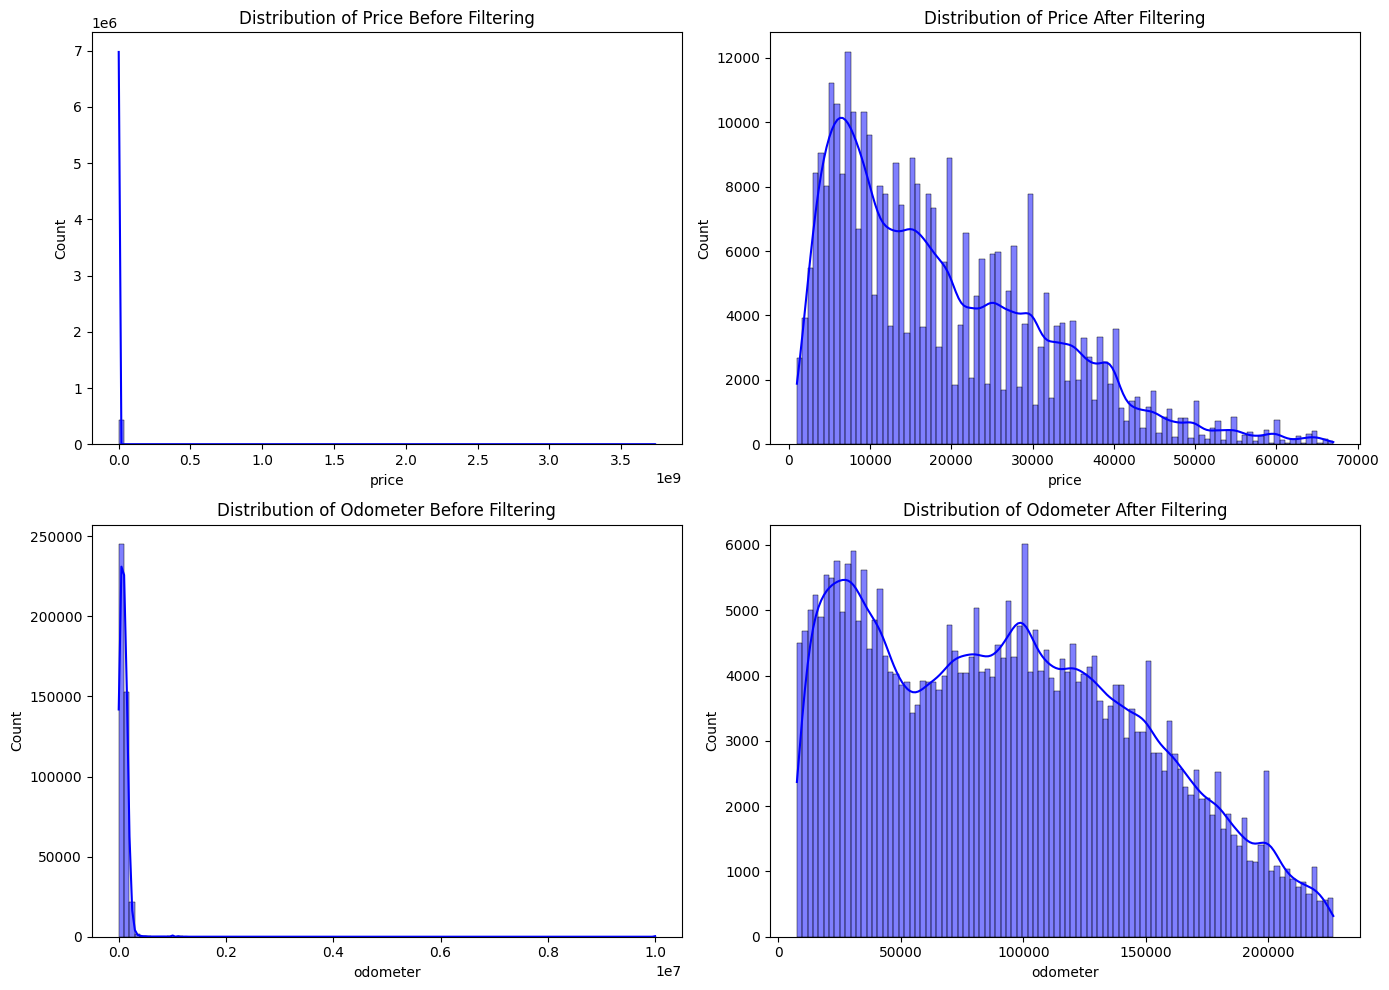

In [15]:
# Create 2x2 subplot grid for visual comparison before and after filtering
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot price distribution before filtering
sns.histplot(data['price'], bins=100, kde=True, color='blue', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Price Before Filtering')

# Plot odometer distribution before filtering
sns.histplot(data['odometer'], bins=100, kde=True, color='blue', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Odometer Before Filtering')

# Apply filtering to remove extreme price and odometer values
data = data[(data['price'] > 1000) & (data['price'] < data['price'].quantile(0.99))]
data = data[(data['odometer'] > data['odometer'].quantile(0.05)) & (data['odometer'] < data['odometer'].quantile(0.97))]

# Plot price distribution after filtering
sns.histplot(data['price'], bins=100, kde=True, color='blue', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Price After Filtering')

# Plot odometer distribution after filtering
sns.histplot(data['odometer'], bins=100, kde=True, color='blue', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Odometer After Filtering')

plt.tight_layout()
plt.show()


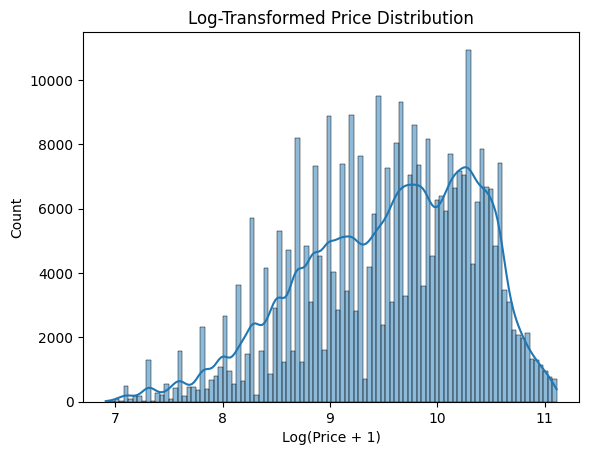

In [16]:
data['y'] = np.log1p(data['price'])  # Apply log(1 + price) to handle skewness 
sns.histplot(data['y'], bins=100, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price + 1)')
plt.show()


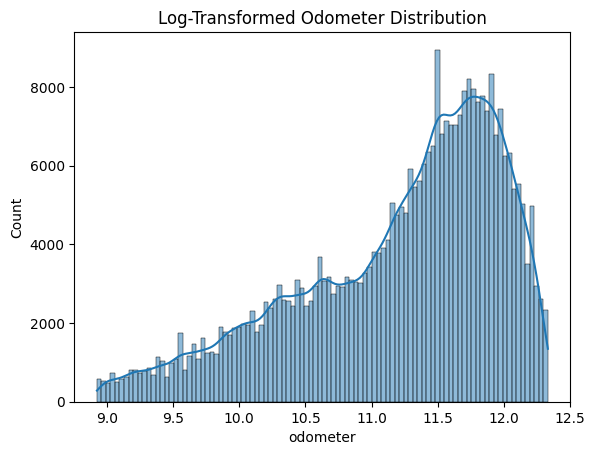

In [17]:
data['odometer'] = np.log1p(data['odometer'])  # Log-transform odometer to reduce skewness
sns.histplot(data['odometer'], bins=100, kde=True)
plt.title('Log-Transformed Odometer Distribution')
plt.show()


In [18]:
# Create imputers for categorical and numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # Use mode for categorical data
num_imputer = SimpleImputer(strategy='mean')           # Use mean for numerical data

# Impute missing values in categorical columns
data[cats] = cat_imputer.fit_transform(data[cats])

# Impute missing values in numerical columns
data[nums] = num_imputer.fit_transform(data[nums])


In [19]:
#Check Total Missing Values After Imputation
data.isna().sum().sum()
# Save to CSV
data.to_csv("car_data.csv", index=False)

### Encoding Categorical Variables

This block factorizes each categorical feature, converting its string labels into numeric codes.  
Factorization assigns a unique integer to each category, which helps machine learning models process categorical data efficiently.


In [20]:
for i in cats:
    enc = data[i]
    enc,_ = pd.factorize(enc)
    data[i] = enc.astype("float32")

In [21]:
# Reset the DataFrame index after filtering and cleaning to ensure it is sequential and clean
data = data.reset_index(drop=True)


### Feature Engineering

- Created `car_age` to represent vehicle age instead of using the raw `year` feature.
- Added `age_per_mile` to capture how intensively the car has been used.
- Clustered geographic coordinates (`lat`, `long`) using KMeans to capture regional effects.
- Applied frequency encoding for high-cardinality categorical features (`model` and `region`).
- Generated new interaction features by combining pairs of categorical variables to capture complex relationships.


In [22]:
# More informative feature than raw 'year': calculate car age
data['car_age'] = 2025 - data['year']

# Interaction feature: age per mile to capture usage intensity, helps models learn non-linear effects
data['age_per_mile'] = data['car_age'] / (data['odometer'] + 1)

# Cluster geographic coordinates to capture possible regional price variation
coords = data[['lat', 'long']]
kmeans = KMeans(n_clusters=10, random_state=123).fit(coords)
data['loc_cluster'] = kmeans.labels_

# Frequency encoding for high-cardinality categorical features like 'model' and 'region'
model_freq = data['model'].value_counts().to_dict()
data['model_freq'] = data['model'].map(model_freq)

region_freq = data['region'].value_counts().to_dict()
data['region_freq'] = data['region'].map(region_freq)

# Create new features combining pairs of categorical variables to capture interactions
PAIRS = []
for i, c1 in enumerate(cats[:-1]):
    for j, c2 in enumerate(cats[i+1:]):
        n = f"{c1}_{c2}"
        m2 = data[c2].max() + 1
        # Combine two categorical features into a single integer feature to capture pairwise interaction
        data[n] = ((data[c1] + 1 + (data[c2] + 1) / (m2 + 1)) * (m2 + 1)).astype("int8")
        
        COMBO.append(n)
        PAIRS.append(n)


In [23]:
# Define the target variable as the log-transformed price
target = 'y'

# Combine categorical, numerical, and engineered feature columns into a single list for modeling
FEATURES = cats + nums + COMBO

In [24]:
# 'loc_cluster' encodes regional grouping of similar latitude and longitude points,
# so keeping raw 'lat' and 'long' would be redundant and add noise.
# Also, since we created 'car_age', the raw 'year' column is no longer needed.

to_remove = ['lat', 'long', 'year']
data.drop(to_remove, axis=1, inplace=True)

# Remove dropped columns from FEATURES list
FEATURES = [f for f in FEATURES if f not in to_remove]

# Add newly engineered features to FEATURES
FEATURES += ['car_age', 'age_per_mile', 'loc_cluster', 'model_freq', 'region_freq']

print(f"We now have {len(FEATURES)} columns: \n              {FEATURES}")


We now have 150 columns: 
              ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'odometer', 'NaNs', 'region_nan_year', 'region_nan_odometer', 'region_nan_lat', 'region_nan_long', 'manufacturer_nan_year', 'manufacturer_nan_odometer', 'manufacturer_nan_lat', 'manufacturer_nan_long', 'model_nan_year', 'model_nan_odometer', 'model_nan_lat', 'model_nan_long', 'condition_nan_year', 'condition_nan_odometer', 'condition_nan_lat', 'condition_nan_long', 'cylinders_nan_year', 'cylinders_nan_odometer', 'cylinders_nan_lat', 'cylinders_nan_long', 'fuel_nan_year', 'fuel_nan_odometer', 'fuel_nan_lat', 'fuel_nan_long', 'title_status_nan_year', 'title_status_nan_odometer', 'title_status_nan_lat', 'title_status_nan_long', 'transmission_nan_year', 'transmission_nan_odometer', 'transmission_nan_lat', 'transmission_nan_long', 'drive_nan_year', 'drive_nan_odometer', 'drive_nan_lat', 'drive_nan_long'

# XGBoost with Feature Engineering and GroupBy Imputation

In [25]:
# Importing necessary libraries for model training and evaluation:
# KFold for cross-validation splits,
# XGBRegressor as the regression model,
# and printing the XGBoost library version to ensure compatibility.
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
print(f"XGBoost version", xgb.__version__)


XGBoost version 2.0.3


In [26]:
# Define statistical measures to aggregate for grouped features:
STATS = ["mean", "std", "count", "nunique", "median", "min", "max", "skew"]
STATS2 = ["mean"]  # A simpler list for specific aggregations

# Define the number of bins for histograms for further aggregations
BINS = 10

# Function to create histograms for price data within a specified range and bins
def make_histogram(prices, bins=BINS, range_min=15, range_max=150):
    hist, _ = np.histogram(prices, bins=bins, range=(range_min, range_max))
    return hist


In [27]:
import cudf
from sklearn.model_selection import train_test_split
%load_ext cudf.pandas


# Split the dataset into training and testing sets (80% train, 20% test)
train, test = train_test_split(data, test_size=0.20, random_state=42)
# Reset the indices of train and test sets after the split
train = train.reset_index()
test = test.reset_index()

# Print the shapes of the resulting datasets to verify the split
print(train.shape)
print(test.shape)

(274524, 153)
(68632, 153)


### 📘 Overview: Nested K-Fold Training with Target Encoding & Histogram Features

In this notebook, we build a powerful machine learning pipeline for a regression task using **nested K-Fold cross-validation** with **target encoding** and **histogram-based features**. The aim is to prevent data leakage and extract rich statistical features from the target variable (`y`) for model training.

#### 🔍 What This Code Does:

- Performs **outer K-Fold cross-validation** to robustly evaluate model performance.
- Within each outer fold, applies an **inner K-Fold** to create **target-encoded features**, ensuring no leakage.
- Encodes features based on:
  - Single columns (e.g., `odometer`)
  - Feature combinations from the `COMBO` list
  - Histogram binning of target values for distribution-based features
- Constructs additional derived features:
  - Ratios like `std/count`, `count/nunique`, and `count**2/std`
- Converts selected columns to categorical dtype for XGBoost compatibility.

#### ⚡ GPU-Accelerated XGBoost Regressor

- Utilizes **XGBoost with GPU support (`device='cuda'`)** for faster training.
- Incorporates **early stopping** for efficient model convergence.
- Trains on the enriched dataset with both original and engineered features.

#### 📈 Prediction Aggregation

- `oof_preds`: Out-of-fold predictions used to evaluate model performance on unseen data.
- `test_preds`: Averaged test predictions over all outer folds for robust final output.

This architecture helps capture **complex target distributions** while maintaining generalization through **nested validation**.


In [28]:
%%time

FOLDS = 4
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))   # Out-of-fold predictions
pred = np.zeros((len(test)))   # Test predictions

# ----------------------- OUTER K-FOLD -----------------------
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"{'-'*44} OUTER Fold {i+1} {'-'*44}")

    X_train = train.loc[train_index,FEATURES+['y']].reset_index(drop=True).copy()
    y_train = train.loc[train_index,'y']

    X_valid = train.loc[test_index,FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index,'y']

    X_test = test[FEATURES].reset_index(drop=True).copy()
    

    # ---------------- INNER K-FOLD FOR TARGET ENCODING ----------------
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f"{'-'*37} INNER Fold {j+1} (outer fold {i+1}) {'-'*36}")

        X_train2 = X_train.loc[train_index2,FEATURES+['y']].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()

        tmp_features = []
        
        # --- Feature Set 1: Target Encoding by Odometer using STATS ---
        col = "odometer"
        tmp = X_train2.groupby(col).y.agg(STATS)
        tmp.columns = [f"TE1_om_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left").reset_index(drop=True)
        
        X_train.loc[test_index2, tmp.columns] = X_valid2[tmp.columns].astype("float32").values
        
        


        
      
        # --- Feature Set 2: Target Encoding for Combinations ---
        
        for col in COMBO:
            tmp = X_train2.groupby(col).y.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            # Merge with X_valid2
            X_valid2_temp = X_valid2.merge(tmp, on=col, how="left").reset_index(drop=True)
            new_cols = [c for c in tmp.columns if c.startswith("TE1_om_")]
            # Assign to X_train at test_index2
            X_train.loc[test_index2, new_cols] = X_valid2_temp[new_cols].astype("float32").values
            

        # --- Feature Set 3: Histogram Features ---
        
        tmp = X_train2.groupby("odometer")[["y"]].agg("count")
        tmp.columns = ['ct']
        X_train3 = X_train2.merge(tmp.loc[tmp['ct']>1],on="odometer",how="left")
        result = X_train3.groupby("odometer")["y"].apply(make_histogram)
        result = result.to_frame()['y'].apply(pd.Series)
        result.columns = [f"histogram_{x}" for x in range(BINS)]
        
        X_valid2 = X_valid2.merge(result, on="odometer", how="left").reset_index(drop=True)
        
        # Assign histogram features
        histogram_cols = [f"histogram_{x}" for x in range(BINS)]
        X_train.loc[test_index2, histogram_cols] = X_valid2[histogram_cols].astype("float32").values
            
        # Clean up
        del result, X_train3, tmp, X_train2, X_valid2,X_valid2_temp
        gc.collect()
    
    # ---------- Final Feature Creation for Validation and Test Sets ----------
    # --- TE1 on odometer ---
    col = "odometer"
    tmp = X_train.groupby(col).y.agg(STATS)
    tmp.columns = [f"TE1_om_{s}" for s in STATS]
    tmp = tmp.astype("float32")
    X_valid = X_valid.merge(tmp, on=col, how="left").reset_index(drop=True)
    X_test = X_test.merge(tmp, on=col, how="left").reset_index(drop=True)
    

    # --- TE2 on COMBO ---
    
    for col in COMBO:
        tmp = X_train.groupby(col).y.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        tmp = tmp.astype("float32")
    
        X_valid = X_valid.merge(tmp, on=col, how="left").reset_index(drop=True)
        X_test = X_test.merge(tmp, on=col, how="left").reset_index(drop=True) 
    
    

    
    # --- Histogram features ---
    # AGGREGATE HISTOGRAMS (uses price)
    tmp = X_train.groupby("odometer")[["y"]].agg("count")
    tmp.columns = ['ct']
    X_train3 = X_train.merge(tmp.loc[tmp['ct']>1],on="odometer",how="left")
    result = X_train3.groupby("odometer")["y"].apply(make_histogram)
    result = result.to_frame()['y'].apply(pd.Series)
    result.columns = [f"histogram_{x}" for x in range(BINS)]
    result = result.astype("float32")
    X_valid = X_valid.merge(result, on="odometer", how="left").reset_index(drop=True)
    X_test = X_test.merge(result, on="odometer", how="left").reset_index(drop=True)
    del result, X_train3, tmp
    

    # Additional Features
    # COUNT PER NUNIQUE
    X_train['TE1_om_count_per_nunique'] = X_train['TE1_om_count']/X_train['TE1_om_nunique']
    X_valid['TE1_om_count_per_nunique'] = X_valid['TE1_om_count']/X_valid['TE1_om_nunique']
    X_test['TE1_om_count_per_nunique'] = X_test['TE1_om_count']/X_test['TE1_om_nunique']

    
    # STD PER COUNT
    X_train['TE1_om_std_per_count'] = X_train['TE1_om_std']/X_train['TE1_om_count']
    X_valid['TE1_om_std_per_count'] = X_valid['TE1_om_std']/X_valid['TE1_om_count']
    X_test['TE1_om_std_per_count'] = X_test['TE1_om_std']/X_test['TE1_om_count']

    # Prepare data for XGBoost
    X_train[cats] = X_train[cats].astype("category").copy()
    X_valid[cats] = X_valid[cats].astype("category").copy()
    X_test[cats] = X_test[cats].astype("category").copy()

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['y'],axis=1)
    # DROP NON-TE CAT PAIRS
    X_train = X_train.drop(PAIRS,axis=1).copy()
    X_valid = X_valid.drop(PAIRS,axis=1).copy()
    X_test = X_test.drop(PAIRS,axis=1).copy()
    colls = list(X_train.columns)

    # Ensure these are DataFrames
    X_train = pd.DataFrame(X_train,columns=colls)
    X_valid = pd.DataFrame(X_valid,columns=colls)
    X_test = pd.DataFrame(X_test,columns=colls)
    # Set target series correctly
    y_train = pd.DataFrame(y_train, columns=['y'])
    y_valid = pd.DataFrame(y_valid, columns=['y'])

    # --------------------- Train Model ---------------------
    model = XGBRegressor(
        device="cuda",
        max_depth=6,  
        colsample_bynode=0.3, 
        subsample=0.8,  
        n_estimators=100_000,  
        learning_rate=0.01,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=200,
        
    )
    
    COLS = X_train.columns.to_list() 

     # Ensure these are DataFrames
    X_train = pd.DataFrame(X_train,columns =COLS)
    X_valid = pd.DataFrame(X_valid,columns =COLS)
    X_test = pd.DataFrame(X_test,columns =COLS)
    # Set target series correctly
    y_train = pd.DataFrame(y_train, columns=['y'])
    y_valid = pd.DataFrame(y_valid, columns=['y'])


    model.fit(
        X_train[COLS], y_train['y'],
        eval_set=[(X_valid[COLS], y_valid['y'])],  
        verbose=10000,
    )

    # --------------------- Predict ---------------------
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

    # --------------------- Clean Up ---------------------
    del X_train, X_valid, X_test
    del y_train, y_valid
    if i != FOLDS-1: del model
    gc.collect()

# Average predictions from all outer folds
pred /= FOLDS

-------------------------------------------- OUTER Fold 1 --------------------------------------------
------------------------------------- INNER Fold 1 (outer fold 1) ------------------------------------
------------------------------------- INNER Fold 2 (outer fold 1) ------------------------------------
------------------------------------- INNER Fold 3 (outer fold 1) ------------------------------------
------------------------------------- INNER Fold 4 (outer fold 1) ------------------------------------
[0]	validation_0-rmse:0.79476
[10000]	validation_0-rmse:0.25471
[20000]	validation_0-rmse:0.24571
[30000]	validation_0-rmse:0.24171
[40000]	validation_0-rmse:0.23937
[50000]	validation_0-rmse:0.23785
[60000]	validation_0-rmse:0.23687
[70000]	validation_0-rmse:0.23620
[80000]	validation_0-rmse:0.23574
[90000]	validation_0-rmse:0.23540
[99999]	validation_0-rmse:0.23514
-------------------------------------------- OUTER Fold 2 --------------------------------------------
------------

In [29]:
# COMPUTE overall cross-validation (CV) score for train
# Compute the Root Mean Squared Error (RMSE) between out-of-fold predictions and true values


true_s = train.y.values
s = np.sqrt(np.mean((oof - true_s) ** 2.0))

print(f"=> Overall CV Score(train - log_price) = {s} ")

=> Overall CV Score(train - log_price) = 0.23848500929380073 


In [30]:
# COMPUTE overall cross-validation (CV) score for test
# Compute the Root Mean Squared Error (RMSE) between predictions and true values

true_s = test.y.values
s = np.sqrt(np.mean( (pred-true_s)**2.0 ) )
print(f"=> Overall CV Score(test - log_price) = {s}")

=> Overall CV Score(test - log_price) = 0.22994033253134083


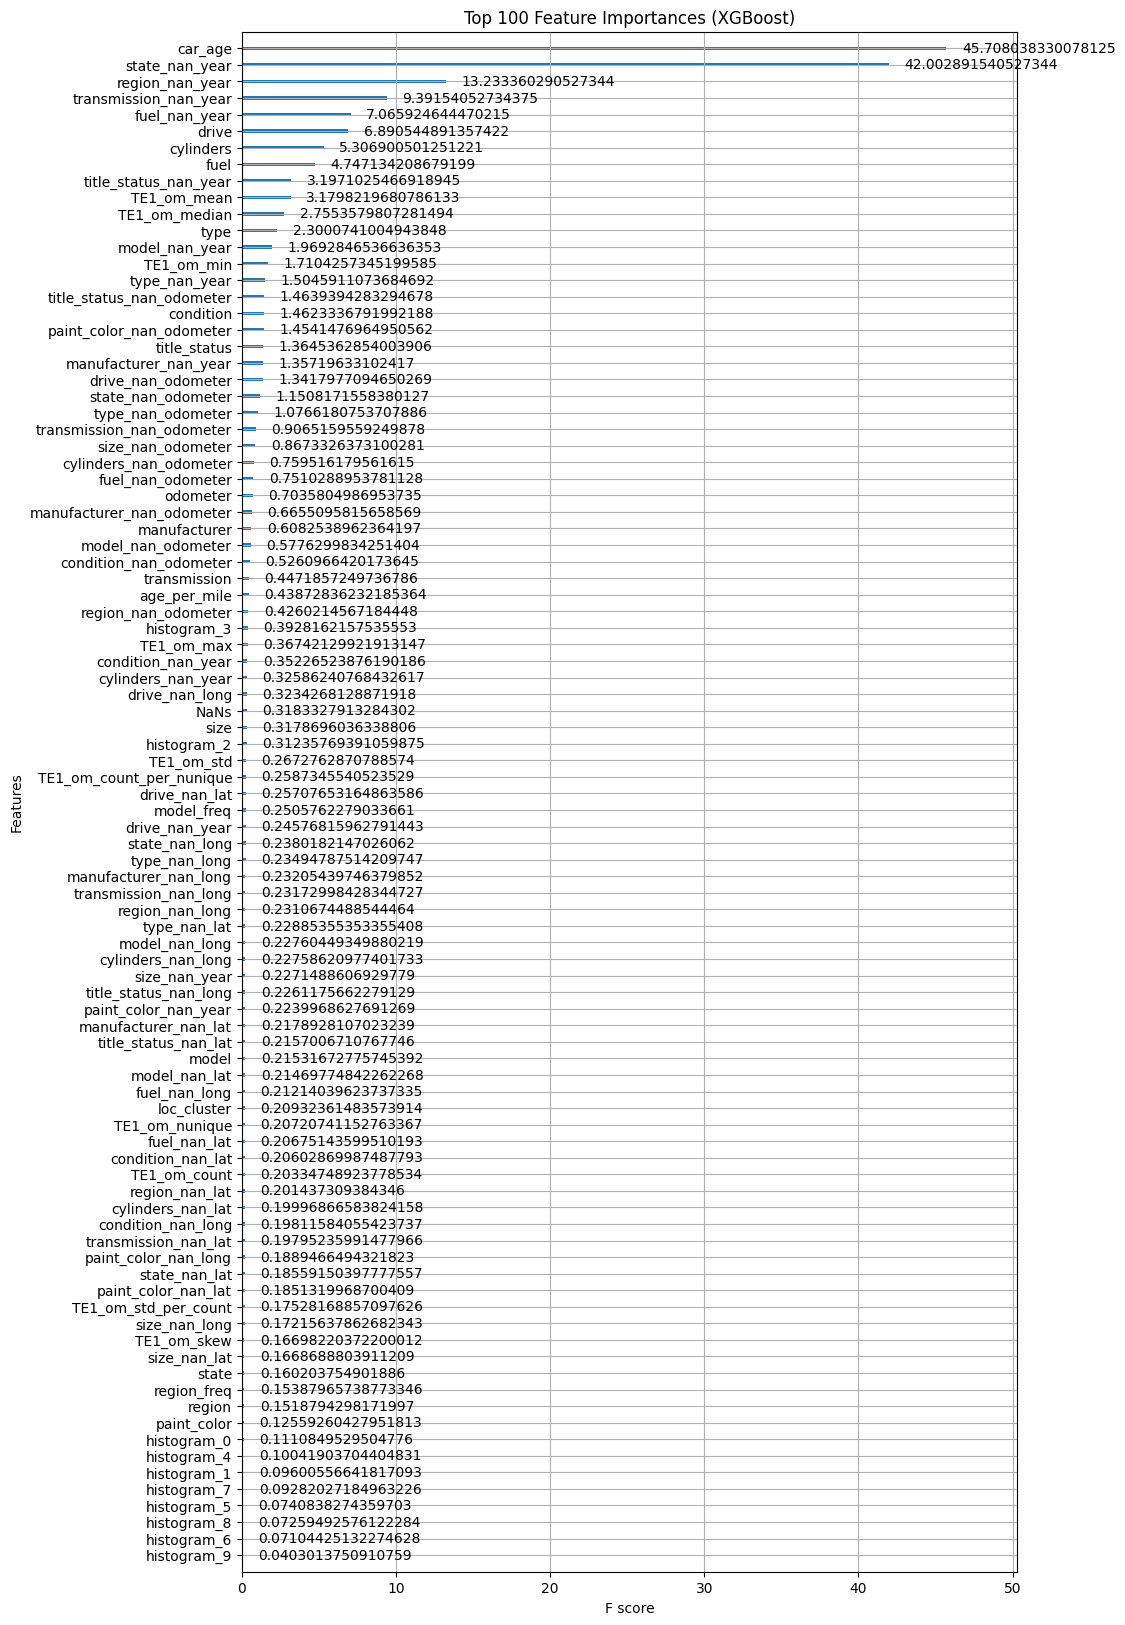

In [31]:
# Plot the top 100 features based on gain importance
model.get_booster().feature_names = COLS

fig, ax = plt.subplots(figsize=(10, 20))

xgb.plot_importance(model, 
                    max_num_features=100, 
                    importance_type='gain', 
                    ax=ax)

plt.title("Top 100 Feature Importances (XGBoost)")   # Set the plot title

plt.show()

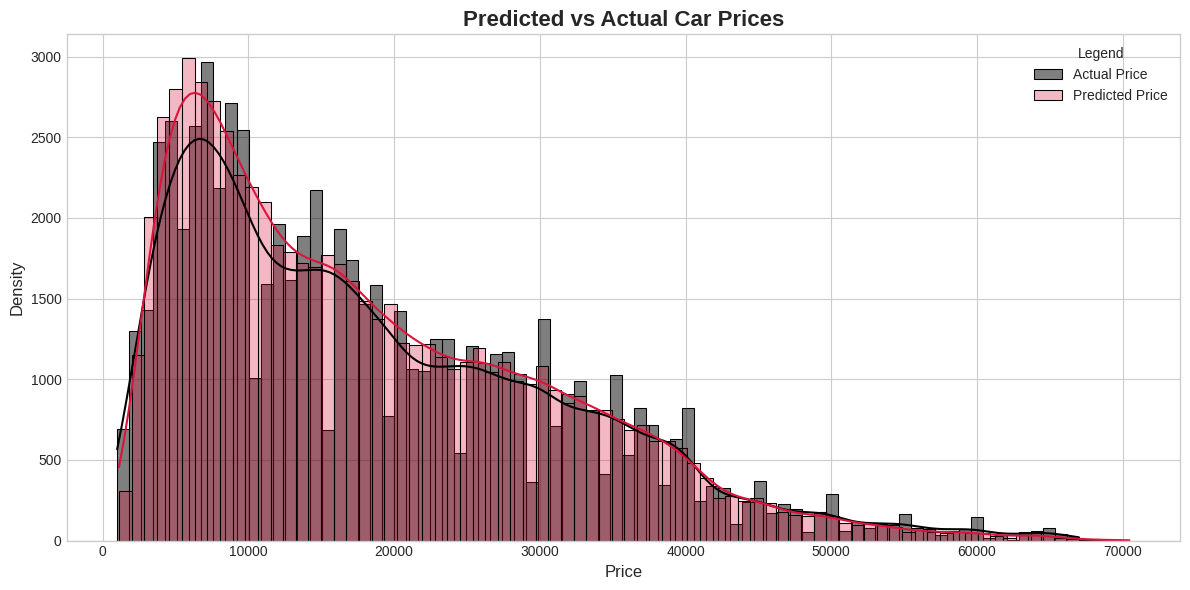

In [32]:
# Convert predicted log prices back to original scale
pred_price = np.exp(pred) - 1

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

# Plot actual vs predicted price distributions
sns.histplot(test['price'], color='black', alpha=0.5, bins=80, kde=True, label='Actual Price')
sns.histplot(pred_price, color='crimson', alpha=0.3, bins=80, kde=True, label='Predicted Price')

# Improve title, labels, and legend
plt.title("Predicted vs Actual Car Prices", fontsize=16, fontweight='bold')
plt.xlabel("Price", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title='Legend', fontsize=10)
plt.tight_layout()

# Show plot
plt.show()


# Conclusion

This notebook presented a thorough approach to predicting car prices by leveraging advanced feature engineering, including target encoding and histogram aggregations, while carefully preventing data leakage through nested cross-validation.

We utilized a GPU-accelerated XGBoost regressor, achieving strong performance as validated by out-of-fold metrics and distribution comparisons between predicted and actual prices.


**Future work could focus on further feature exploration, hyperparameter tuning (`n_estimators=150_000, early_stopping_rounds=500`) also decrease learning rate, and model deployment for practical applications.** 

This pipeline offers a solid foundation for accurate and reliable regression modeling on structured datasets.


In [33]:
# Create .csv files
pred_car = pd.DataFrame({
    
    'Price': pred_price
})

# Save to CSV
pred_car.to_csv("pred_car.csv", index=False)
test.to_csv("test_car.csv",index=False)

display(pred_car.head(5))
display(test.head(5))

,Price
0,39265.420798
1,4874.753352
2,22794.647200
3,32537.092519
4,14347.554108


,index,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,NaNs,region_nan_year,region_nan_odometer,region_nan_lat,region_nan_long,manufacturer_nan_year,manufacturer_nan_odometer,manufacturer_nan_lat,manufacturer_nan_long,model_nan_year,model_nan_odometer,model_nan_lat,model_nan_long,condition_nan_year,condition_nan_odometer,condition_nan_lat,condition_nan_long,cylinders_nan_year,cylinders_nan_odometer,cylinders_nan_lat,cylinders_nan_long,fuel_nan_year,fuel_nan_odometer,fuel_nan_lat,fuel_nan_long,title_status_nan_year,title_status_nan_odometer,title_status_nan_lat,title_status_nan_long,transmission_nan_year,transmission_nan_odometer,transmission_nan_lat,transmission_nan_long,drive_nan_year,drive_nan_odometer,drive_nan_lat,drive_nan_long,size_nan_year,size_nan_odometer,size_nan_lat,size_nan_long,type_nan_year,type_nan_odometer,type_nan_lat,type_nan_long,paint_color_nan_year,paint_color_nan_odometer,paint_color_nan_lat,paint_color_nan_long,state_nan_year,state_nan_odometer,state_nan_lat,state_nan_long,y,car_age,age_per_mile,loc_cluster,model_freq,region_freq,region_manufacturer,region_model,region_condition,region_cylinders,region_fuel,region_title_status,region_transmission,region_drive,region_size,region_type,region_paint_color,region_state,manufacturer_model,manufacturer_condition,manufacturer_cylinders,manufacturer_fuel,manufacturer_title_status,manufacturer_transmission,manufacturer_drive,manufacturer_size,manufacturer_type,manufacturer_paint_color,manufacturer_state,model_condition,model_cylinders,model_fuel,model_title_status,model_transmission,model_drive,model_size,model_type,model_paint_color,model_state,condition_cylinders,condition_fuel,condition_title_status,condition_transmission,condition_drive,condition_size,condition_type,condition_paint_color,condition_state,cylinders_fuel,cylinders_title_status,cylinders_transmission,cylinders_drive,cylinders_size,cylinders_type,cylinders_paint_color,cylinders_state,fuel_title_status,fuel_transmission,fuel_drive,fuel_size,fuel_type,fuel_paint_color,fuel_state,title_status_transmission,title_status_drive,title_status_size,title_status_type,title_status_paint_color,title_status_state,transmission_drive,transmission_size,transmission_type,transmission_paint_color,transmission_state,drive_size,drive_type,drive_paint_color,drive_state,size_type,size_paint_color,size_state,type_paint_color,type_state,paint_color_state
0,11710,19.0,39590,33.0,1805.0,0.0,6.0,4.0,9.976831,0.0,0.0,1.0,0.0,7.0,0.0,2.0,528.0,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2141.0,21643.0,154.210007,11.040000,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2141.0,21643.0,154.210007,11.040000,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,2041.0,21543.0,54.209999,-88.959999,10.586357,6.0,0.546606,4,275,2513,126,114,-115,-69,125,-115,81,82,101,32,5,19,56,-17,57,-47,-17,-119,-118,-85,-28,-69,-21,99,-123,89,99,57,58,71,-52,-73,-37,16,11,8,5,6,6,22,14,55,47,50,29,30,36,106,92,111,36,21,22,26,78,66,7,5,6,6,22,14,55,6,6,22,14,55,11,36,27,107,22,14,55,105,-93,55
1,328016,384.0,4595,2.0,23629.0,0.0,2.0,0.0,12.251127,0.0,1.0,2.0,1.0,7.0,3.0,47.0,512.0,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2129.0,209338.0,169.877594,-0.270000,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,2029.0,209238.0,69.877602,-100.269997,8.432942,18.0,1.358375,8,1,2123,-82,-109,-120,-116,7,-120,6,7,-121,22,-111,100,-99,22,30,19,22,14,